In [20]:
import sys, os, time, urllib, json

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt # pip install matplotlib contextily
import contextily as ctx

from shapely.geometry import box
from GOSTrocks.misc import tPrint
from space2stats_client import Space2StatsClient
from tqdm.notebook import tqdm

sys.path.insert(0, "C:/WBG/Work/Code/GOSTrocks/src")
import GOSTrocks.dataMisc as dMisc

import requests
requests.packages.urllib3.disable_warnings()

In [2]:
def gdf_esri_service(url, layer=0):
    """Download a GeoPandas dataframe from an ESRI service

    Parameters
    ----------
    url : str
        URL to the ESRI service without the layer number
    layer : int, optional
        Layer number to download, by default 0

    Returns
    -------
    gpd.GeoDataFrame
        GeoDataFrame of the data

    https://medium.com/@jesse.b.nestler/how-to-extract-every-feature-from-an-esri-map-service-using-python-b6e34743574a
    """
    # Look at metadata of url 
    with urllib.request.urlopen(f'{url}/?f=pjson') as service_url:
        service_data = json.loads(service_url.read().decode())

    queryable = ['Query' in service_data['capabilities']]

    if queryable:
        query_url = f"{url}/{layer}/query"
        # get total number of records in complete service
        n_queries = service_data['maxRecordCount']
        count_query = {"outFields": "*", "where": "1=1", "returnCountOnly": True, 'f':'json'}
        count_str = urllib.parse.urlencode(count_query)
        with urllib.request.urlopen(f'{query_url}?{count_str}') as count_url:
            count_json = json.loads(count_url.read().decode())
            n_records = count_json['count']
        if n_records < n_queries: #We can download all the data in a single query
            all_records_query = {"outFields": "*", "where": "1=1", "returnGeometry": True, "f": "geojson"}
            query_str = urllib.parse.urlencode(all_records_query)
            all_query_url = f"{query_url}?{query_str}"
            return gpd.read_file(all_query_url)
        else:
            step_query = {"outFields": "*", "where": "1=1", "returnGeometry": True,"f": "geojson",
                        'resultRecordCount': n_queries, "resultOffset": 0}
            for offset in range(0, n_records, n_queries):
                step_query['resultOffset'] = offset
                query_str = urllib.parse.urlencode(step_query)
                step_query_url = f"{query_url}?{query_str}"                
                cur_res = gpd.read_file(step_query_url)
                if offset == 0:
                    gdf = cur_res
                else:
                    gdf = pd.concat([gdf, cur_res])
            return gdf
    else:
        raise ValueError("Service is not queryable :(")

In [3]:
'''
adm_summary_url = "https://ddh-openapi.worldbank.org/resources/DR0095355/data?"
inD = requests.get(adm_summary_url, verify=False).json()
inD = pd.DataFrame(inD['value'])

'''

adm_summary_file = r"C:\Users\WB411133\Downloads\adm2_flood_exposure_15cm_1in100.csv"
inD = pd.read_csv(adm_summary_file)
inADM0 = inD.groupby('ISO3').agg({'pop':'sum','pop_flood':'sum'}).reset_index()

In [5]:
# Download adm boundaries from WB_GAD
wb_gad_url = "https://services.arcgis.com/iQ1dY19aHwbSDYIF/arcgis/rest/services/World_Bank_Global_Administrative_Divisions/FeatureServer"

adm0 = gdf_esri_service(wb_gad_url, layer=1)
#adm1 = gdf_esri_service(wb_gad_url, layer=2)
adm2 = gdf_esri_service(wb_gad_url, layer=3)

In [24]:
inADM0['pop_flood_pct'] = inADM0['pop_flood'] / inADM0['pop']
adm_combo = pd.merge(adm0, inADM0, left_on='ISO_A3', right_on='ISO3', how='left')

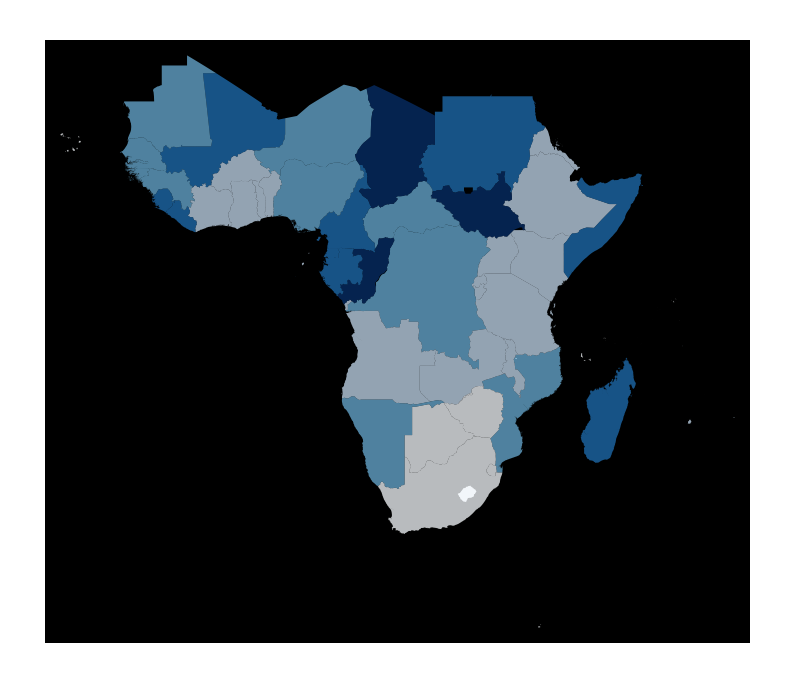

In [23]:
adm0_map = adm_combo.loc[adm_combo['WB_REGION'] == 'AFR']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adm0_map.plot(ax=ax, column="pop_flood_pct", 
         legend=False, cmap="Blues", alpha=0.75, 
         scheme="equal_interval", k=5, 
         legend_kwds=dict(title='% Pop. Exposed', fmt="{:.0%}"),
         linewidth=0)

xMin, yMin, xMax, yMax = adm0_map.total_bounds
bbox = gpd.GeoDataFrame(geometry=[box(xMin-2, yMin-2, xMax+2, yMax+2)], crs=adm0_map.crs)
bbox.plot(ax=ax, color="black", zorder=0)

#ctx.add_basemap(ax, source=ctx.providers.Esri.WorldPhysical, crs=3857)
plt.axis("off")
plt.show()

In [69]:
adm0_map = adm_combo.loc[adm_combo['WB_REGION'] == 'AFR']
adm0_map.to_file("C:/Temp/adm0_flooded.gpkg", driver='gpkg')

In [72]:
adm2.head()

,FID,ISO_A3,ISO_A2,WB_A3,WB_REGION,WB_STATUS,NAM_0,NAM_1,ADM1CD_c,GEOM_SRCE,NAM_2,ADM2CD_c,GlobalID,Shape__Area,Shape__Length,geometry
0,1,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,Hefei,CHN001006,53c750e7-82c3-470d-9ed2-f47ccba33311,0.714030,4.658247,"POLYGON ((117.85668 32.02414, 117.76963 31.992..."
1,2,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,Bengbu,CHN001002,3305c0a9-1aeb-4cbc-a85a-93de4b704602,0.573573,3.860499,"POLYGON ((117.94735 33.3384, 117.95826 33.2954..."
2,3,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,Huainan,CHN001008,7b8c5527-3b9a-4f0b-bb4e-22f566c4a18a,0.199664,2.216914,"POLYGON ((117.20039 32.63284, 117.11077 32.626..."
3,4,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,Huaibei,CHN001007,88015d93-7849-461c-ac78-2caa4f8d621e,0.222556,2.424015,"POLYGON ((116.88567 33.37158, 116.85864 33.306..."
4,5,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,Name Unknown,CHN001012,9a6b60e9-7551-40b6-8ca8-43979d61aa73,1.806457,7.153259,"POLYGON ((116.80599 33.30873, 116.81557 33.266..."


In [73]:
adm1_shp = gpd.read_file(r"C:\WBG\Work\data\ADMIN\NEW_WB_BOUNDS\FOR_PUBLICATION\gpkg\WB_GAD_ADM1.gpkg")

# Merge adm2 with inD to get adm1 codes
print(adm2.shape)
adm2_combo = pd.merge(adm2, inD, left_on=['ADM2CD_c'], right_on=['ADM2CD_c'], how='left')
print(adm2_combo.shape)

#Group by ADM1CD_c to get adm1 level data
adm1 = adm2_combo.groupby(['ADM1CD_c']).agg({'pop':'sum','pop_flood':'sum'}).reset_index()
# Join to adm1 geodataframe
adm1_combo = pd.merge(adm1, adm1_shp, left_on='ADM1CD_c', right_on='ADM1CD_c', how='left')

(39370, 16)
(39370, 20)


In [74]:
adm1_combo.shape

(3591, 12)

In [75]:
# Convert combo to geodataframe
adm1_combo = gpd.GeoDataFrame(adm1_combo, geometry='geometry', crs=adm1_shp.crs)
# Calculate # pop_flood_pct
adm1_combo['pop_flood_pct'] = adm1_combo['pop_flood'] / adm1_combo['pop']

In [80]:
adm1_combo.head()

,ADM1CD_c,pop,pop_flood,ISO_A3,ISO_A2,WB_A3,WB_REGION,WB_STATUS,NAM_0,NAM_1,GEOM_SRCE,geometry,pop_flood_pct
0,ABW001,8.248922e+04,5746.259676,ABW,AW,ABW,Other,Territory,Aruba (Neth.),Administrative unit not available,WB GAD,"MULTIPOLYGON (((-70.05108 12.5654, -70.04885 1...",0.069661
1,AFG001,1.235874e+06,143398.849390,AFG,AF,AFG,SAR,Member State,Afghanistan,Badakhshan,WB GAD,"MULTIPOLYGON (((70.10776 37.01419, 70.1068 37....",0.116030
2,AFG002,6.581729e+05,86627.857259,AFG,AF,AFG,SAR,Member State,Afghanistan,Badghis,WB GAD,"MULTIPOLYGON (((63.06486 34.64376, 63.06281 34...",0.131619
3,AFG003,9.692849e+05,162409.320844,AFG,AF,AFG,SAR,Member State,Afghanistan,Baghlan,WB GAD,"MULTIPOLYGON (((69.36685 35.42336, 69.36497 35...",0.167556
4,AFG004,1.340889e+06,211418.411087,AFG,AF,AFG,SAR,Member State,Afghanistan,Balkh,WB GAD,"MULTIPOLYGON (((66.511 36.766, 66.52098 36.766...",0.157670


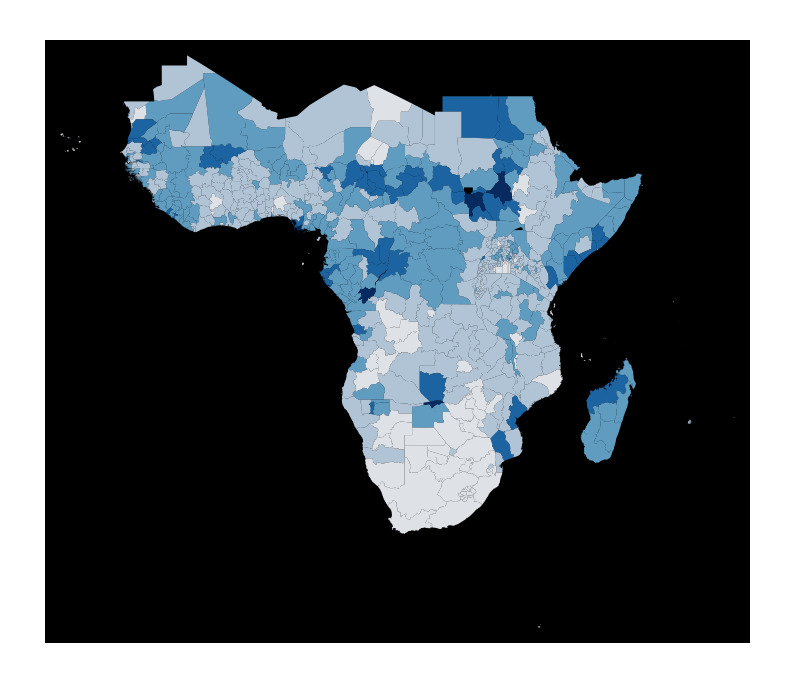

In [82]:
adm2_map = adm1_combo.loc[adm1_combo['WB_REGION'] == 'AFR'].copy()
# Replace all values above 100 in pop_flood_pct with 100
adm2_map.loc[adm2_map['pop_flood_pct'] > 100,'pop_flood_pct'] = 100

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adm2_map.plot(ax=ax, column="pop_flood_pct", 
         legend=False, cmap="Blues", alpha=0.9, 
         scheme="natural_breaks", k=5,
         #scheme="user_defined", classification_kwds={'bins':[5,25,50,75,100]},
         legend_kwds=dict(title='% Pop. Exposed'),
         linewidth=0)

xMin, yMin, xMax, yMax = adm2_map.total_bounds
bbox = gpd.GeoDataFrame(geometry=[box(xMin-2, yMin-2, xMax+2, yMax+2)], crs=adm2_map.crs)
bbox.plot(ax=ax, color="black", zorder=0)

#ctx.add_basemap(ax, source=ctx.providers.Esri.WorldPhysical, crs=3857)
plt.axis("off")
plt.show()

In [68]:
adm2_map = adm2_combo.loc[adm2_combo['WB_REGION'] == 'AFR'].copy()
adm2_map.drop(['FID'], axis=1).to_file("C:/temp/adm2_flooded.gpkg", driver='gpkg')

In [66]:
adm2_combo.head()

,FID,ISO_A3,ISO_A2,WB_A3,WB_REGION,WB_STATUS,NAM_0,NAM_1,ADM1CD_c,GEOM_SRCE,...,ADM2CD_c_x,GlobalID,Shape__Area,Shape__Length,geometry,ADM2CD_c_y,pop,pop_flood,pop_flood_pct,ISO3
0,1,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,...,CHN001006,53c750e7-82c3-470d-9ed2-f47ccba33311,0.71403,4.658247,"POLYGON ((117.85668 32.02414, 117.76963 31.992...",CHN001001,5.398266e+06,1.051061e+06,96.024312,CHN
1,1,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,...,CHN001006,53c750e7-82c3-470d-9ed2-f47ccba33311,0.71403,4.658247,"POLYGON ((117.85668 32.02414, 117.76963 31.992...",CHN001002,3.031089e+06,5.116088e+05,39.948947,CHN
2,1,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,...,CHN001006,53c750e7-82c3-470d-9ed2-f47ccba33311,0.71403,4.658247,"POLYGON ((117.85668 32.02414, 117.76963 31.992...",CHN001003,3.929601e+06,1.022011e+06,81.747570,CHN
3,1,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,...,CHN001006,53c750e7-82c3-470d-9ed2-f47ccba33311,0.71403,4.658247,"POLYGON ((117.85668 32.02414, 117.76963 31.992...",CHN001004,1.486484e+06,3.867708e+05,53.077011,CHN
4,1,CHN,CN,CHN,EAP,Member State,China,Anhui Sheng,CHN001,WB GAD,...,CHN001006,53c750e7-82c3-470d-9ed2-f47ccba33311,0.71403,4.658247,"POLYGON ((117.85668 32.02414, 117.76963 31.992...",CHN001005,3.874482e+06,5.335936e+05,63.264552,CHN
